# ANALYSIS JAPANESE BIOBANK CH DATA

#### Data from: Saiki et al 2021, Nat Med, Combined landscape of single-nucleotide variants and copy number alterations in clonal hematopoiesis https://www.nature.com/articles/s41591-021-01411-9

### 1. Get Japanese Biobank exclusive mutations in 12 BoostDM genes (only SNVs)
### 2. Create positive set
### 3. Create negative set
### 4. Evaluation BoostDM vs Expert curated rules - 9 genes together
### 5. Evaluation BoostDM vs Expert curated rules - gene by gene

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO
import copy
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 30)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from matplotlib import rcParams

## 1. Get and arrange data

In [2]:
### Open Saiki et al. Mutations

japan_ch = pd.read_csv("/workspace/datasets/ddbjapan_CH/J-DU000618/JGAS000293/JGAD000399/JGAZ000005792/MatMed_2021_mut_table.txt", sep='\t')
print(len(japan_ch))
japan_ch.columns

12219


/tmp/jobs/jramis/9874679/ipykernel_8057/3726592395.py:3: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,47,52,53,56,57,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  japan_ch = pd.read_csv("/workspace/datasets/ddbjapan_CH/J-DU000618/JGAS000293/JGAD000399/JGAZ000005792/MatMed_2021_mut_table.txt", sep='\t')


Index(['id', 'sex', 'age', 'Chr', 'Start', 'End', 'Ref', 'Alt', 'Func.refGene',
       'Gene.refGene', 'GeneDetail.refGene', 'ExonicFunc.refGene',
       'Merge_Func', 'AAChange.refGene', 'cytoBand', 'genomicSuperDups',
       'esp6500siv2_all', 'X1000g2010nov_all', 'X1000g2014oct_all',
       'X1000g2014oct_afr', 'X1000g2014oct_eas', 'X1000g2014oct_eur', 'snp131',
       'snp138', 'snp131NonFlagged', 'snp138NonFlagged', 'cosmic68wgs',
       'cosmic70', 'clinvar_20150629', 'SIFT_score', 'SIFT_pred',
       'Polyphen2_HDIV_score', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_score',
       'Polyphen2_HVAR_pred', 'LRT_score', 'LRT_pred', 'MutationTaster_score',
       'MutationTaster_pred', 'MutationAssessor_score',
       'MutationAssessor_pred', 'FATHMM_score', 'FATHMM_pred',
       'RadialSVM_score', 'RadialSVM_pred', 'LR_score', 'LR_pred',
       'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP.._RS',
       'phyloP46way_placental', 'phyloP100way_vertebrate',
       'SiPhy_29way_logOdds', '

In [3]:
japan_mutations = japan_ch[japan_ch['Start'].notna()]

In [4]:
japan_mutations['Gene.refGene'].value_counts()

DNMT3A           1706
TET2             1235
ASXL1             255
PPM1D             164
TP53              148
SF3B1             116
SRSF2              73
CBL                65
GNB1               60
JAK2               53
U2AF1;U2AF1L5      43
GNAS               27
EZH2               25
IDH2               23
RUNX1              19
NRAS               11
KRAS               10
ETV6                7
MYD88               6
IDH1                5
CEBPA               4
GATA2               1
Name: Gene.refGene, dtype: int64

In [5]:
len(set(japan_mutations.id))

3071

In [6]:
### Genes

# Get gene columns
genes_ch = japan_mutations['Gene.refGene']
print(set(genes_ch))
genes_ch.value_counts()

{'CBL', 'RUNX1', 'GNAS', 'PPM1D', 'IDH1', 'TP53', 'SRSF2', 'MYD88', 'EZH2', 'IDH2', 'SF3B1', 'JAK2', 'TET2', 'U2AF1;U2AF1L5', 'GATA2', 'KRAS', 'ASXL1', 'DNMT3A', 'NRAS', 'CEBPA', 'GNB1', 'ETV6'}


DNMT3A           1706
TET2             1235
ASXL1             255
PPM1D             164
TP53              148
SF3B1             116
SRSF2              73
CBL                65
GNB1               60
JAK2               53
U2AF1;U2AF1L5      43
GNAS               27
EZH2               25
IDH2               23
RUNX1              19
NRAS               11
KRAS               10
ETV6                7
MYD88               6
IDH1                5
CEBPA               4
GATA2               1
Name: Gene.refGene, dtype: int64

In [7]:
japan_mutations['ExonicFunc.refGene'].value_counts()

nonsynonymous SNV          1890
frameshift deletion         860
stopgain                    653
frameshift insertion        356
nonframeshift deletion       85
nonframeshift insertion       6
synonymous SNV                4
stoploss                      2
Name: ExonicFunc.refGene, dtype: int64

In [8]:
### Select only SNVs

japan_mutations_sel = japan_mutations[japan_mutations['Ref'].isin(['A','C','T','G']) &
                              japan_mutations['Alt'].isin(['A','C','T','G'])].reset_index(drop=True)
print(japan_mutations_sel['ExonicFunc.refGene'].value_counts())

nonsynonymous SNV    1889
stopgain              611
synonymous SNV          4
stoploss                2
Name: ExonicFunc.refGene, dtype: int64


In [9]:
### Arrange data
# Change chromosome nomenclature
japan_mutations_sel['Chr'] = japan_mutations_sel['Chr'].astype(int)

In [10]:
### Get position hg38

from pyliftover import LiftOver
lo = LiftOver('hg19', 'hg38')

def hg38_conv (x):
    try:
        hg38 = lo.convert_coordinate('chr' + str(x['Chr']), x['Start'])[0][1]
        return hg38
    except:
        print('WARNING: not transformed')
        print(x['Chromosome'], x['Start_Position'])

# Apply to 12 genes selection
japan_mutations_sel['pos_hg38'] = japan_mutations_sel.apply(lambda x: hg38_conv(x), axis=1)

In [11]:
### Substitute U2AF1;U2AF1L5  by U2AF1

japan_mutations_sel['Gene.refGene'] = japan_mutations_sel['Gene.refGene'].apply(lambda x: x.split(';')[0])
japan_mutations_sel['Gene.refGene'].value_counts()

DNMT3A    1218
TET2       642
TP53       139
SF3B1      115
ASXL1      109
SRSF2       66
PPM1D       64
GNB1        60
CBL         57
JAK2        50
U2AF1       43
GNAS        27
IDH2        23
EZH2        20
RUNX1       15
KRAS        10
NRAS        10
MYD88        6
ETV6         6
IDH1         5
CEBPA        2
GATA2        1
Name: Gene.refGene, dtype: int64

In [12]:
### Select 12 Ch genes

genes12 = ['ASXL1', 'CHEK2', 'DNMT3A', 'GNAS', 'IDH2', 'MDM4', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']
japan_mutations_sel = japan_mutations_sel[japan_mutations_sel['Gene.refGene'].isin(genes12)]
print(len(japan_mutations_sel))
japan_mutations_sel['Gene.refGene'].value_counts()

2446


DNMT3A    1218
TET2       642
TP53       139
SF3B1      115
ASXL1      109
SRSF2       66
PPM1D       64
U2AF1       43
GNAS        27
IDH2        23
Name: Gene.refGene, dtype: int64

In [13]:
### Select unique mutations
japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt']].drop_duplicates().reset_index(drop=True)

,Chr,Gene.refGene,pos_hg38,Ref,Alt
0,20,ASXL1,32434485.0,C,A
1,20,ASXL1,32433321.0,G,A
2,20,ASXL1,32429984.0,A,G
3,20,ASXL1,32435050.0,C,T
4,20,ASXL1,32435516.0,C,G
...,...,...,...,...,...
1320,17,TP53,7675218.0,T,C
1321,17,TP53,7674241.0,G,A
1322,17,TP53,7675157.0,G,C
1323,21,U2AF1,43104346.0,G,A


In [14]:
#eliminate mutations in introns
japan_mutations_sel = japan_mutations_sel[-japan_mutations_sel['AAChange.refGene'].isna()]
print(len(japan_mutations_sel))

2267


In [15]:
### Get AA change
japan_mutations_sel['aachange'] = japan_mutations_sel['AAChange.refGene'].apply(lambda x: x.split(':')[-1].split('.')[-1])


## 2. Create positive set

In [16]:
### Get positive set of unique
japan_mutations_unq = japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt', 'aachange']].drop_duplicates().reset_index(drop=True)
japan_mutations_unq

,Chr,Gene.refGene,pos_hg38,Ref,Alt,aachange
0,20,ASXL1,32434485.0,C,A,Y591X
1,20,ASXL1,32433321.0,G,A,V375M
2,20,ASXL1,32429984.0,A,G,I217V
3,20,ASXL1,32435050.0,C,T,Q780X
4,20,ASXL1,32435516.0,C,G,P935R
...,...,...,...,...,...,...
1214,17,TP53,7675218.0,T,C,K93E
1215,17,TP53,7674241.0,G,A,S202F
1216,17,TP53,7675157.0,G,C,P113R
1217,21,U2AF1,43104346.0,G,A,S34F


In [17]:
### Change names
japan_mutations_unq = japan_mutations_unq.rename(columns={'Gene.refGene':'gene', 'Chr':'chr', 'pos_hg38':'pos',
                                   'Ref':'ref', 'Alt':'alt'})
japan_mutations_unq = japan_mutations_unq[['gene','chr','pos','ref','alt','aachange']]
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange
0,ASXL1,20,32434485.0,C,A,Y591X
1,ASXL1,20,32433321.0,G,A,V375M
2,ASXL1,20,32429984.0,A,G,I217V
3,ASXL1,20,32435050.0,C,T,Q780X
4,ASXL1,20,32435516.0,C,G,P935R
...,...,...,...,...,...,...
1214,TP53,17,7675218.0,T,C,K93E
1215,TP53,17,7674241.0,G,A,S202F
1216,TP53,17,7675157.0,G,C,P113R
1217,U2AF1,21,43104346.0,G,A,S34F


In [18]:
#gene frequency
japan_mutations_unq['gene'].value_counts()

DNMT3A    505
TET2      423
TP53       96
ASXL1      83
SF3B1      43
PPM1D      31
SRSF2      15
U2AF1      11
GNAS        9
IDH2        3
Name: gene, dtype: int64

In [19]:
#gene frequency
japan_mutations_unq['gene'].value_counts(normalize=True)*100

DNMT3A    41.427400
TET2      34.700574
TP53       7.875308
ASXL1      6.808860
SF3B1      3.527482
PPM1D      2.543068
SRSF2      1.230517
U2AF1      0.902379
GNAS       0.738310
IDH2       0.246103
Name: gene, dtype: float64

In [20]:
### Create variable of set
japan_mutations_unq['Set'] = 1
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange,Set
0,ASXL1,20,32434485.0,C,A,Y591X,1
1,ASXL1,20,32433321.0,G,A,V375M,1
2,ASXL1,20,32429984.0,A,G,I217V,1
3,ASXL1,20,32435050.0,C,T,Q780X,1
4,ASXL1,20,32435516.0,C,G,P935R,1
...,...,...,...,...,...,...,...
1214,TP53,17,7675218.0,T,C,K93E,1
1215,TP53,17,7674241.0,G,A,S202F,1
1216,TP53,17,7675157.0,G,C,P113R,1
1217,U2AF1,21,43104346.0,G,A,S34F,1


In [21]:
### Create dictionary

gene_frec_pos = dict(japan_mutations_unq['gene'].value_counts())
gene_frec_pos

{'DNMT3A': 505,
 'TET2': 423,
 'TP53': 96,
 'ASXL1': 83,
 'SF3B1': 43,
 'PPM1D': 31,
 'SRSF2': 15,
 'U2AF1': 11,
 'GNAS': 9,
 'IDH2': 3}

# 3. Create negative set

### 3.1. MSKCC

In [22]:
# Open observed mutaitons from MSKCC
MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",
                          sep='\t')
print(len(MSKCC_IMPACT))
MSKCC_IMPACT.columns

246585


/tmp/jobs/jramis/9874679/ipykernel_8057/484754725.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [23]:
### MSK negative
MSKCC_negative = MSKCC_IMPACT[MSKCC_IMPACT['response'] == 0].reset_index(drop=True)
print(len(MSKCC_negative))

241750


### 3.2. TCGA

In [24]:
# Open TCGA observed mutations
TCGA = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_TCGA_FULL.regression_data.tsv",
                          sep='\t')
print(len(TCGA))
TCGA.columns

23205


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [25]:
### MSK negative
TCGA_negative = TCGA[TCGA['response'] == 0].reset_index(drop=True)
len(TCGA_negative)

22750

### 3.2. HMF

In [26]:
# Open TCGA observed mutations
HMF = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WGS_HMF_FULL.regression_data.tsv",
                          sep='\t')
print(len(HMF))
HMF.columns

10047


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [27]:
### MSK negative
HMF_negative = HMF[HMF['response'] == 0].reset_index(drop=True)
len(HMF_negative)

9850

### 3.4. General negative set

In [28]:
### Concatenate 3 db

negative_set = pd.concat([MSKCC_negative, TCGA_negative, HMF_negative]).reset_index(drop=True)
len(negative_set)

274350

In [29]:
### Select 12 genes

# Select 12 genes
negative_set = negative_set[negative_set['gene'].isin(genes12)].reset_index(drop=True)
len(negative_set)

226200

In [30]:
### Type of mutations

negative_set[['csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing', 'csqn_type_synonymous']].sum()

csqn_type_missense      154759
csqn_type_nonsense       11800
csqn_type_splicing        1963
csqn_type_synonymous     57313
dtype: int64

In [31]:
# Genes
negative_set['gene'].value_counts()

DNMT3A    132500
TET2       26900
PPM1D      18450
TP53       13300
CHEK2      10150
ASXL1       8950
SF3B1       5550
SRSF2       3350
GNAS        2250
U2AF1       2150
MDM4        1450
IDH2        1200
Name: gene, dtype: int64

In [32]:
### Select unique

negative_set_unq = negative_set[['gene','chr','pos','ref','alt','aachange']].drop_duplicates().reset_index(drop=True)
negative_set_unq['Set'] = 0
negative_set_unq

,gene,chr,pos,ref,alt,aachange,Set
0,ASXL1,20,32433867,A,T,T557S,0
1,ASXL1,20,32433508,A,G,K437R,0
2,ASXL1,20,32434642,G,T,G644W,0
3,ASXL1,20,32431429,T,A,L276*,0
4,ASXL1,20,32431661,C,T,R321W,0
...,...,...,...,...,...,...,...
53767,U2AF1,21,43094758,C,A,V127L,0
53768,U2AF1,21,43094734,A,G,F135L,0
53769,U2AF1,21,43107477,G,A,A6A,0
53770,U2AF1,21,43100485,T,C,Q56R,0


### Check no SNV are in both negative and positive

In [33]:
japan_mutations_unq['pos'] = japan_mutations_unq['pos'].astype('int')
japan_mutations_unq['chr'] = japan_mutations_unq['chr'].astype('int')

japan_mutations_unq = japan_mutations_unq.drop_duplicates()
japan_mutations_unq.gene.value_counts()

DNMT3A    505
TET2      423
TP53       96
ASXL1      83
SF3B1      43
PPM1D      31
SRSF2      15
U2AF1      11
GNAS        9
IDH2        3
Name: gene, dtype: int64

In [34]:
### Create dictionary

gene_frec_pos = dict(japan_mutations_unq['gene'].value_counts())
gene_frec_pos

{'DNMT3A': 505,
 'TET2': 423,
 'TP53': 96,
 'ASXL1': 83,
 'SF3B1': 43,
 'PPM1D': 31,
 'SRSF2': 15,
 'U2AF1': 11,
 'GNAS': 9,
 'IDH2': 3}

In [35]:
negative_set_unq['pos'] = negative_set_unq['pos'].astype('int')
negative_set_unq['chr'] = negative_set_unq['chr'].astype('int')

negative_set_unq = negative_set_unq.drop_duplicates()
negative_set_unq

,gene,chr,pos,ref,alt,aachange,Set
0,ASXL1,20,32433867,A,T,T557S,0
1,ASXL1,20,32433508,A,G,K437R,0
2,ASXL1,20,32434642,G,T,G644W,0
3,ASXL1,20,32431429,T,A,L276*,0
4,ASXL1,20,32431661,C,T,R321W,0
...,...,...,...,...,...,...,...
53760,U2AF1,21,43095535,T,G,E84A,0
53761,U2AF1,21,43093116,A,T,S237T,0
53766,U2AF1,21,43094709,T,A,E143V,0
53769,U2AF1,21,43107477,G,A,A6A,0


# 4. Evaluation BoostDM vs Expert curated rules - 9 genes together

In [36]:
### Get file with BoostDM + Harvard predicitons

boostDM_harvard = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_run20230803.tsv.gz', sep='\t')
boostDM_harvard

,gene,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,row,Prot_pos,Niroula,Bick,CNIC,WHO
0,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,C,K2Q,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000014,0,-0.111320,0.0,0.0,0.000000,-0.442670,-0.308238,0.0,0.0,0.0,0.0,0.0,-1.168175,-2.783079,-0.099647,0.030009,0,2,0.0,0.0,0.0,0.0
1,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,G,K2E,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000014,0,-0.111320,0.0,0.0,0.000000,-0.442670,-0.308238,0.0,0.0,0.0,0.0,0.0,-1.168175,-2.783079,-0.099647,0.030009,1,2,0.0,0.0,0.0,0.0
2,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,T,K2*,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.989503,1,-0.151095,0.0,0.0,0.000000,-0.304486,-0.415152,0.0,0.0,0.0,0.0,0.0,0.371912,2.419656,-0.038151,0.070408,2,2,0.0,0.0,0.0,0.0
3,ASXL1,ENST00000375687,ENSG00000171456,20,32358780,C,K2T,0.0,0,0,0,1.708984,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000011,0,-0.118665,0.0,0.0,0.000000,-0.550868,-0.296171,0.0,0.0,0.0,0.0,0.0,-1.170185,-2.774794,-0.099765,0.029898,3,2,0.0,0.0,0.0,0.0
4,ASXL1,ENST00000375687,ENSG00000171456,20,32358780,G,K2R,0.0,0,0,0,1.708984,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000011,0,-0.118665,0.0,0.0,0.000000,-0.550868,-0.296171,0.0,0.0,0.0,0.0,0.0,-1.170185,-2.774794,-0.099765,0.029898,4,2,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,ENST00000291552,ENSG00000160201,21,43107490,C,A2G,0.0,0,0,0,7.027344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002605,0,-0.256177,0.0,0.0,-1.502649,-0.791911,0.000000,0.0,0.0,0.0,0.0,0.0,0.000850,0.000000,0.000000,0.000005,2146,2,0.0,0.0,0.0,0.0
87935,U2AF1,ENST00000291552,ENSG00000160201,21,43107490,T,A2E,0.0,0,0,0,7.027344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002605,0,-0.256177,0.0,0.0,-1.502649,-0.791911,0.000000,0.0,0.0,0.0,0.0,0.0,0.000850,0.000000,0.000000,0.000005,2147,2,0.0,0.0,0.0,0.0
87936,U2AF1,ENST00000291552,ENSG00000160201,21,43107491,A,A2S,0.0,0,0,0,5.570312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002207,0,-0.236594,0.0,0.0,-1.493413,-0.893124,0.000000,0.0,0.0,0.0,0.0,0.0,0.000854,0.000000,0.000000,0.000005,2148,2,0.0,0.0,0.0,0.0
87937,U2AF1,ENST00000291552,ENSG00000160201,21,43107491,G,A2P,0.0,0,0,0,5.570312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002207,0,-0.236594,0.0,0.0,-1.493413,-0.893124,0.000000,0.0,0.0,0.0,0.0,0.0,0.000854,0.000000,0.000000,0.000005,2149,2,0.0,0.0,0.0,0.0


In [37]:
### Import rule-based deffinition of CH

import sys
sys.path.append("../../../Paper_data/Expert_curated_rules/")
from CH_harvard import niroula_CH
from CH_harvard import bick_CH
from CH_harvard import WHO_CH

### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['Set']==1) & (data[method]==1)])
    tn = len(data[(data['Set']==0) & (data[method]==0)])
    fp = len(data[(data['Set']==0) & (data[method]==1)])
    fn = len(data[(data['Set']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [38]:
genes = japan_mutations_unq.gene.value_counts().reset_index()
genes = genes[genes['gene']>5]['index'].tolist()
genes

['DNMT3A', 'TET2', 'TP53', 'ASXL1', 'SF3B1', 'PPM1D', 'SRSF2', 'U2AF1', 'GNAS']

In [39]:
eval_boostdm = []
eval_niroula = []
eval_bick = []
eval_who = []


for i in range(50):
    ## Set seed random
    seed = 1234 + i
    
    ## Create negative set
    # Empty df
    negative_set = negative_set_unq[negative_set_unq['alt']=='XXXXX']
    # Get negative set with gene frequency equal to positive set
    for gene in genes:
        negative_set_gene = negative_set_unq[negative_set_unq['gene']==gene]
        negative_set = pd.concat([negative_set,
                                  negative_set_gene.sample(gene_frec_pos[gene], random_state=seed)])
    negative_set = negative_set.reset_index(drop=True)
    
    ## Create validation set
    validation_set = pd.concat([japan_mutations_unq[japan_mutations_unq['gene'].isin(genes)], negative_set]).reset_index(drop=True)

    ## Merge with BoostDM & Harvard predictions
    validation_set_predictions = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
    
    ## Calculate all statistics for each method
    for method in ['boostDM_class', 'Niroula', 'Bick', 'WHO']:
        statistics = []
        for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']:    
            # Calculate statistic
            statistics.append(quality_statistic(validation_set_predictions, method=method, statistic=statistic))
        if method == 'boostDM_class': eval_boostdm.append(statistics)
        elif method == 'Niroula': eval_niroula.append(statistics)
        elif method == 'Bick': eval_bick.append(statistics)
        elif method == 'WHO': eval_who.append(statistics) 


In [40]:
# check results (example boostDM)
pd.DataFrame(eval_boostdm)

,0,1,2,3,4,5
0,0.799103,0.786078,0.792079,0.808028,0.765289,0.777778
1,0.800761,0.787080,0.793487,0.810149,0.765289,0.778644
2,0.799655,0.786412,0.792492,0.808734,0.765289,0.777952
3,0.813708,0.794850,0.802642,0.826786,0.765289,0.781874
4,0.810858,0.793148,0.800825,0.823111,0.765289,0.781538
...,...,...,...,...,...,...
45,0.787683,0.779133,0.783416,0.793488,0.765289,0.774065
46,0.795806,0.784081,0.789604,0.803819,0.765289,0.776730
47,0.808592,0.791791,0.799258,0.820195,0.765289,0.781033
48,0.802983,0.788421,0.795052,0.812994,0.765289,0.779160


In [41]:
### Create summary dataframe with means

results_10g = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM_median': pd.DataFrame(eval_boostdm).median(),
                'BoostDM_q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Niroula_median': pd.DataFrame(eval_niroula).median(),
                'Niroula_q1': pd.DataFrame(eval_niroula).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Niroula_q3': pd.DataFrame(eval_niroula).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Bick_median': pd.DataFrame(eval_bick).median(),
                'Bick_q1': pd.DataFrame(eval_bick).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Bick_q3': pd.DataFrame(eval_bick).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'WHO_median': pd.DataFrame(eval_who).median(),
                'WHO_q1': pd.DataFrame(eval_who).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'WHO_q3': pd.DataFrame(eval_who).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],})
results_10g

,Statistic,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,WHO_median,WHO_q1,WHO_q3
0,$F_{50}$,0.803820,0.798138,0.808592,0.755295,0.750069,0.757618,0.786394,0.782669,0.790628,0.760870,0.756757,0.764588
1,F1,0.788924,0.785495,0.791791,0.802517,0.798821,0.804154,0.731550,0.729531,0.733835,0.801356,0.798499,0.803929
2,Accuracy,0.795670,0.791486,0.799217,0.779773,0.774776,0.782268,0.759950,0.757526,0.762612,0.782474,0.778420,0.785869
3,Precision,0.814066,0.806796,0.820195,0.726785,0.720745,0.729475,0.827766,0.822614,0.833640,0.736078,0.731271,0.740431
4,Recall,0.765289,0.765289,0.765289,0.895868,0.895868,0.895868,0.655372,0.655372,0.655372,0.879339,0.879339,0.879339
5,NPV,0.779417,0.777647,0.780822,0.864734,0.863081,0.865815,0.715649,0.714237,0.716712,0.850868,0.849251,0.852077


In [42]:
columns = [x for x in results_10g.columns.tolist() if not x.endswith(('q1', 'q3'))]
reduced_results = results_10g.loc[[0,3,4],columns].reset_index(drop=True)
reduced_results

,Statistic,BoostDM_median,Niroula_median,Bick_median,WHO_median
0,$F_{50}$,0.803820,0.755295,0.786394,0.760870
1,Precision,0.814066,0.726785,0.827766,0.736078
2,Recall,0.765289,0.895868,0.655372,0.879339


In [43]:
error_data = results_10g.iloc[[0, 3, 4],:].reset_index(drop=True)
error_data

,Statistic,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,WHO_median,WHO_q1,WHO_q3
0,$F_{50}$,0.803820,0.798138,0.808592,0.755295,0.750069,0.757618,0.786394,0.782669,0.790628,0.760870,0.756757,0.764588
1,Precision,0.814066,0.806796,0.820195,0.726785,0.720745,0.729475,0.827766,0.822614,0.833640,0.736078,0.731271,0.740431
2,Recall,0.765289,0.765289,0.765289,0.895868,0.895868,0.895868,0.655372,0.655372,0.655372,0.879339,0.879339,0.879339


In [82]:
# SAVE
error_data.to_csv('Japanese_crossvalidation.csv',
                         sep='\t', index=False)

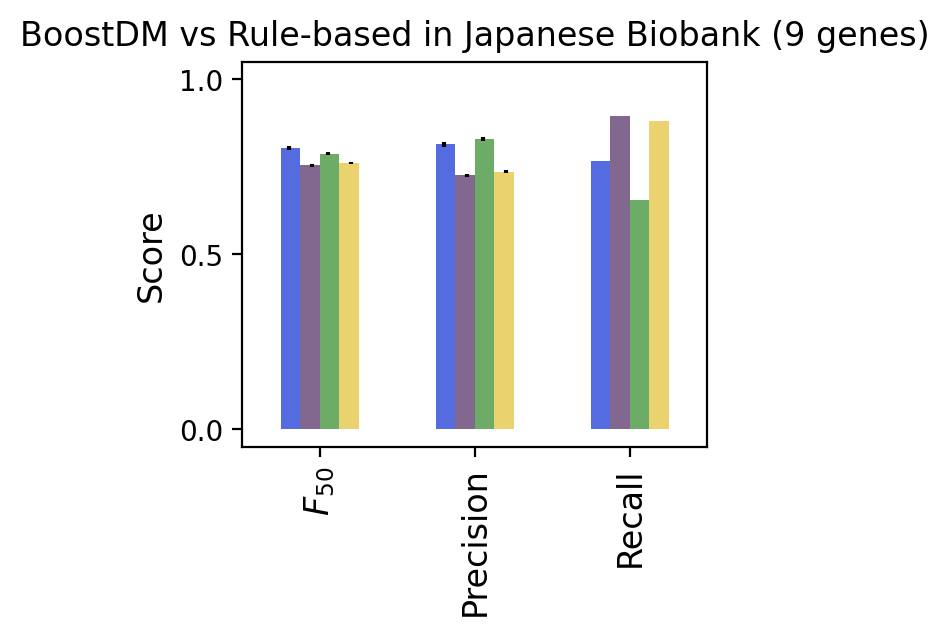

In [44]:
reduced_results.plot.bar(x='Statistic', figsize=(3,2.5), color=['#556CE0', '#82678E', '#6DAC67', '#EAD36E'])

#Add error bar BoostDM
data_Q = error_data[['Statistic', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.BoostDM_median-row.BoostDM_q1], [row.BoostDM_q3-row.BoostDM_median]]
    plt.errorbar(idx-0.2,row.BoostDM_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar Niroula
data_Q = error_data[['Statistic', 'Niroula_median', 'Niroula_q1', 'Niroula_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Niroula_median-row.Niroula_q1], [row.Niroula_q3-row.Niroula_median]]
    plt.errorbar(idx-0.05,row.Niroula_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar Bick
data_Q = error_data[['Statistic', 'Bick_median', 'Bick_q1', 'Bick_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Bick_median-row.Bick_q1], [row.Bick_q3-row.Bick_median]]
    plt.errorbar(idx+0.05,row.Bick_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar WHO
data_Q = error_data[['Statistic', 'WHO_median', 'WHO_q1', 'WHO_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.WHO_median-row.WHO_q1], [row.WHO_q3-row.WHO_median]]
    plt.errorbar(idx+0.2,row.WHO_median, yerr=ci, fmt=' ', ecolor = 'k')
    
plt.title('BoostDM vs Rule-based in Japanese Biobank (9 genes)', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
plt.show()

# 5. Evaluation BoostDM vs Expert curated rules - gene by gene

In [45]:
genes

['DNMT3A', 'TET2', 'TP53', 'ASXL1', 'SF3B1', 'PPM1D', 'SRSF2', 'U2AF1', 'GNAS']

In [46]:
eval_boostdm = []
eval_niroula = []
eval_bick = []
eval_who = []


for i in range(50):
    ## Set seed random
    seed = 1234 + i
    
    ## Create negative set
    # Empty df
    negative_set = negative_set_unq[negative_set_unq['alt']=='XXXXX']
    # Get negative set with gene frequency equal to positive set
    for gene in genes:
        negative_set_gene = negative_set_unq[negative_set_unq['gene']==gene]
        negative_set = pd.concat([negative_set,
                                  negative_set_gene.sample(gene_frec_pos[gene], random_state=seed)])
    negative_set = negative_set.reset_index(drop=True)
    
    ## Create validation set
    validation_set = pd.concat([japan_mutations_unq[japan_mutations_unq['gene'].isin(genes)], negative_set]).reset_index(drop=True)

    ## Merge with BoostDM & Harvard predictions
    validation_set_predictions = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
    
    ## Calculate all statistics for each gene and method
    for gene in genes:
        validation_set_gene = validation_set_predictions[validation_set_predictions['gene']==gene]
        for method in ['boostDM_class', 'Niroula', 'Bick', 'WHO']:
            statistics = []
            for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']:    
                # Calculate statistic
                statistics.append(quality_statistic(validation_set_gene, method=method, statistic=statistic))
            if method == 'boostDM_class': eval_boostdm.append([gene] + statistics)
            elif method == 'Niroula': eval_niroula.append([gene] + statistics)
            elif method == 'Bick': eval_bick.append([gene] + statistics)
            elif method == 'WHO': eval_who.append([gene] + statistics)

In [47]:
# check results (example)
pd.DataFrame(eval_who, columns=['Gene','Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV'])

,Gene,Fscore50,F1,Accuracy,Precision,Recall,NPV
0,DNMT3A,0.699969,0.764310,0.721946,0.662774,0.902584,0.847826
1,TET2,0.804502,0.844639,0.831354,0.779798,0.921241,0.904899
2,TP53,0.761589,0.825112,0.795812,0.724409,0.958333,0.937500
3,ASXL1,0.920635,0.822695,0.849398,1.000000,0.698795,0.768519
4,SF3B1,0.692884,0.747475,0.709302,0.660714,0.860465,0.800000
...,...,...,...,...,...,...,...
445,SF3B1,0.748988,0.787234,0.767442,0.725490,0.860465,0.828571
446,PPM1D,0.935252,0.896552,0.903226,0.962963,0.838710,0.857143
447,SRSF2,0.645161,0.421053,0.633333,1.000000,0.266667,0.576923
448,U2AF1,0.769231,0.666667,0.727273,0.857143,0.545455,0.666667


In [48]:
Stt = 'Fscore50'
results_gene = []
for gene in genes:
    gene_info = [gene]
    for method in [eval_boostdm, eval_niroula, eval_bick, eval_who]: 
        results = pd.DataFrame(method, columns=['Gene','Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV'])
        Stt_list = results[results['Gene']==gene][Stt]
        gene_info.append(Stt_list.median())
        gene_info.append(pd.DataFrame(Stt_list.tolist()).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0][0])
        gene_info.append(pd.DataFrame(Stt_list.tolist()).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0][0])
    results_gene.append(gene_info)

results_dataframe = pd.DataFrame(results_gene)
results_dataframe.columns = ['Gene', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3',
                                 'Niroula_median', 'Niroula_q1', 'Niroula_q3',
                                 'Bick_median', 'Bick_q1', 'Bick_q3',
                                 'WHO_median', 'WHO_q1', 'WHO_q3']
results_dataframe

,Gene,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,WHO_median,WHO_q1,WHO_q3
0,DNMT3A,0.760827,0.755723,0.772178,0.720817,0.714502,0.729938,0.714286,0.711126,0.723009,0.712716,0.701050,0.718355
1,TET2,0.837672,0.824791,0.846081,0.808546,0.800498,0.815378,0.808546,0.800498,0.815378,0.808546,0.800498,0.815378
2,TP53,0.802752,0.783010,0.810185,0.618557,0.612245,0.628272,0.829646,0.815217,0.852273,0.741935,0.727848,0.760337
3,ASXL1,0.886850,0.868287,0.897833,0.897833,0.878812,0.909091,0.897833,0.878812,0.909091,0.897833,0.878812,0.909091
4,SF3B1,0.777778,0.739548,0.801527,0.820513,0.804020,0.855615,0.659341,0.631579,0.659341,0.725490,0.692884,0.748988
5,PPM1D,0.962963,0.935252,0.962963,0.962963,0.935252,0.962963,0.935252,0.935252,0.962963,0.935252,0.935252,0.962963
6,SRSF2,0.813953,0.744681,0.813953,0.641026,0.581395,0.714286,0.714286,0.714286,0.714286,0.645161,0.645161,0.645161
7,U2AF1,0.769231,0.697674,0.857143,0.857143,0.857143,0.857143,0.806452,0.806452,0.806452,0.857143,0.857143,0.857143
8,GNAS,0.384615,0.384615,0.384615,0.588235,0.588235,0.588235,0.384615,0.384615,0.384615,0.384615,0.384615,0.384615


In [50]:
columns = ['Gene']+[x for x in results_dataframe.columns.tolist() if x.endswith('_median')]
reduced_results = results_dataframe.loc[:,columns].reset_index(drop=True)
reduced_results

,Gene,BoostDM_median,Niroula_median,Bick_median,WHO_median
0,DNMT3A,0.760827,0.720817,0.714286,0.712716
1,TET2,0.837672,0.808546,0.808546,0.808546
2,TP53,0.802752,0.618557,0.829646,0.741935
3,ASXL1,0.886850,0.897833,0.897833,0.897833
4,SF3B1,0.777778,0.820513,0.659341,0.725490
5,PPM1D,0.962963,0.962963,0.935252,0.935252
6,SRSF2,0.813953,0.641026,0.714286,0.645161
7,U2AF1,0.769231,0.857143,0.806452,0.857143
8,GNAS,0.384615,0.588235,0.384615,0.384615


In [51]:
Fbeta_10 = reduced_results.set_index(reduced_results.iloc[:, 0].name)
df = Fbeta_10.stack().reset_index()
print(len(df))
df.columns = ['Gene','Method','Accuracy']
df = df[df['Accuracy'].notna()]
df

36


,Gene,Method,Accuracy
0,DNMT3A,BoostDM_median,0.760827
1,DNMT3A,Niroula_median,0.720817
2,DNMT3A,Bick_median,0.714286
3,DNMT3A,WHO_median,0.712716
4,TET2,BoostDM_median,0.837672
...,...,...,...
31,U2AF1,WHO_median,0.857143
32,GNAS,BoostDM_median,0.384615
33,GNAS,Niroula_median,0.588235
34,GNAS,Bick_median,0.384615


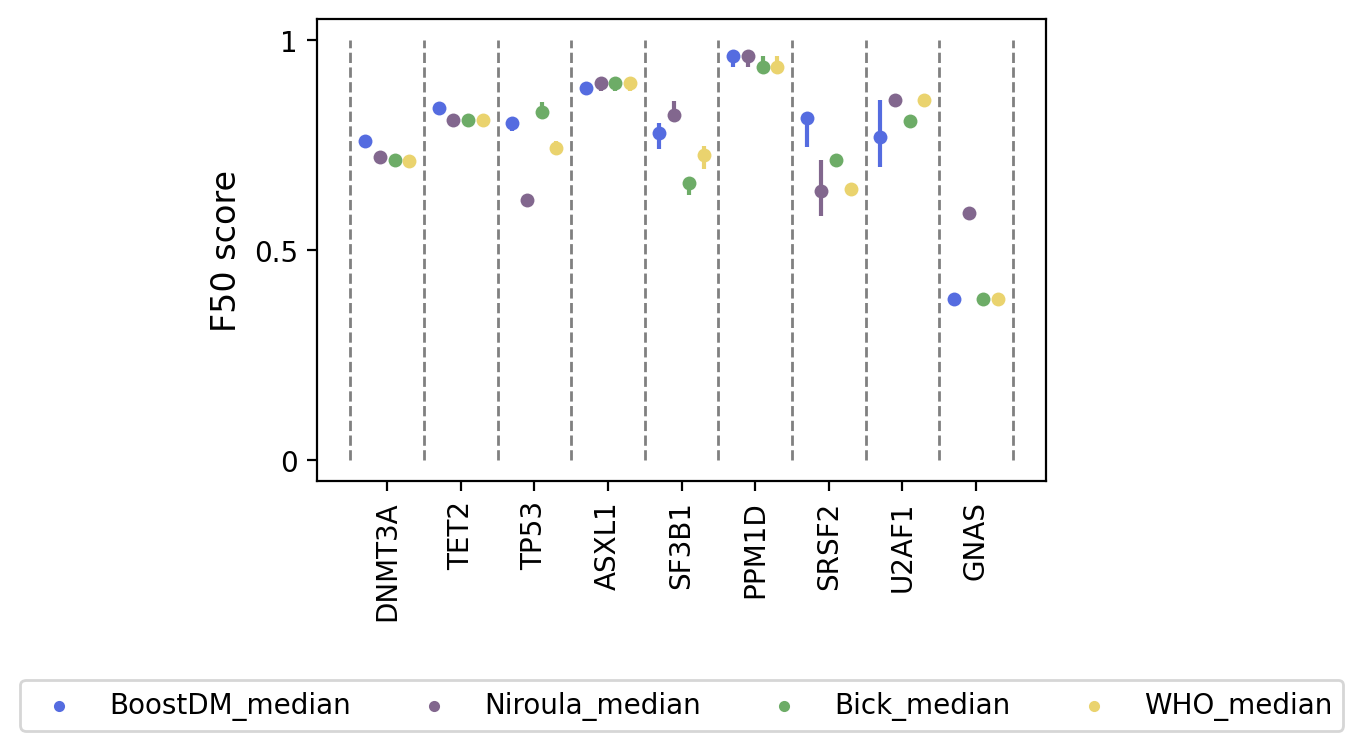

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame containing the data

fig, ax = plt.subplots(figsize=(4.7, 3))
colors = {'BoostDM': '#556CE0', 'Niroula': '#82678E', 'Bick': '#6DAC67', 'WHO': '#EAD36E'}

sns.stripplot(data=df, x="Gene", y="Accuracy", hue="Method", dodge=True,
              palette=['#556CE0', '#82678E', '#6DAC67', '#EAD36E'])

ax.set_ylabel('F50 score', fontsize=12)
ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0', '0.5', '1'])
ax.set_xlabel('')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=4, markerscale=0.5)


for x in range(-1, len(df['Gene'].unique())):
    plt.plot([x + 0.5, x + 0.5], [0, df['Gene'].max()], c='grey', linestyle='dashed', linewidth=1)

#Add error bar BoostDM
data_Q = results_dataframe[['Gene', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.BoostDM_median-row.BoostDM_q1], [row.BoostDM_q3-row.BoostDM_median]]
    plt.errorbar(idx-0.3,row.BoostDM_median, yerr=ci, fmt=' ', ecolor = colors['BoostDM'])

#Add error bar Niroula
data_Q = results_dataframe[['Gene', 'Niroula_median', 'Niroula_q1', 'Niroula_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Niroula_median-row.Niroula_q1], [row.Niroula_q3-row.Niroula_median]]
    plt.errorbar(idx-0.1,row.Niroula_median, yerr=ci, fmt=' ', ecolor = colors['Niroula'])

#Add error bar Bick
data_Q = results_dataframe[['Gene', 'Bick_median', 'Bick_q1', 'Bick_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Bick_median-row.Bick_q1], [row.Bick_q3-row.Bick_median]]
    plt.errorbar(idx+0.1,row.Bick_median, yerr=ci, fmt=' ', ecolor = colors['Bick'])

#Add error bar WHO
data_Q = results_dataframe[['Gene', 'WHO_median', 'WHO_q1', 'WHO_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.WHO_median-row.WHO_q1], [row.WHO_q3-row.WHO_median]]
    plt.errorbar(idx+0.3,row.WHO_median, yerr=ci, fmt=' ', ecolor = colors['WHO'])

plt.show()